<a href="https://colab.research.google.com/github/juricap/jpc/blob/main/Copy_of_keypoint_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pylab import *

rcParams['figure.figsize'] = 16,8

In [ ]:
%pip install -q -U imgaug

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -rf tennis

In [ ]:
!unzip /content/drive/MyDrive/deep/tennisbg.zip

Archive:  /content/drive/MyDrive/deep/tennisbg.zip
   creating: tennis/
   creating: tennis/bg/
  inflating: tennis/bg/court_0000_BG0000.jpg  
  inflating: tennis/bg/court_0001_BG0000.jpg  
  inflating: tennis/bg/court_0002_BG0000.jpg  
  inflating: tennis/bg/court_0003_BG0000.jpg  
  inflating: tennis/bg/court_0004_BG0000.jpg  
  inflating: tennis/bg/court_0005_BG0000.jpg  
  inflating: tennis/bg/court_0006_BG0000.jpg  
  inflating: tennis/bg/court_0007_BG0000.jpg  
  inflating: tennis/bg/court_0008_BG0000.jpg  
  inflating: tennis/bg/court_0009_BG0000.jpg  
  inflating: tennis/bg/court_0010_BG0000.jpg  
  inflating: tennis/bg/court_0011_BG0000.jpg  
  inflating: tennis/bg/court_0012_BG0000.jpg  
  inflating: tennis/bg/court_0013_BG0000.jpg  
  inflating: tennis/bg/court_0014_BG0000.jpg  
  inflating: tennis/bg/court_0015_BG0000.jpg  
  inflating: tennis/bg/court_0016_BG0000.jpg  
  inflating: tennis/bg/court_0017_BG0000.jpg  
  inflating: tennis/bg/court_0018_BG0000.jpg  
  inflating

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa

from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json
import os

In [ ]:
import glob
import json
files = glob.glob('tennis/*.json')
x = json.load(open(files[0],'r',encoding='utf8'))

In [ ]:
files[:5]

['tennis/court_0130.json',
 'tennis/court_0489.json',
 'tennis/court_0249.json',
 'tennis/court_0300.json',
 'tennis/court_0276.json']

## Define hyperparameters

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 4
EPOCHS = 5
NUM_KEYPOINTS = 20 * 2  # 24 pairs each having x and y coordinates

In [ ]:
import numpy as np

def world_to_camera_view(coord,mw,frame):
    co_local = np.dot(inv(mw),np.hstack((coord,1)))
    z = -co_local[2]

    frame = [-(np.array(v) / (v[2] / z)) for v in frame]

    min_x, max_x = frame[2][0], frame[1][0]
    min_y, max_y = frame[1][1], frame[0][1]

    x = (co_local[0] - min_x) / (max_x - min_x)
    y = (co_local[1] - min_y) / (max_y - min_y)

    return (x, y, z)

def trans(params):
    out = []
    for p in params['points']:
        out.append(world_to_camera_view(p,np.array(params['matrix_world']),params['frame']))
    return np.array(out)

tennis/court_0319.json


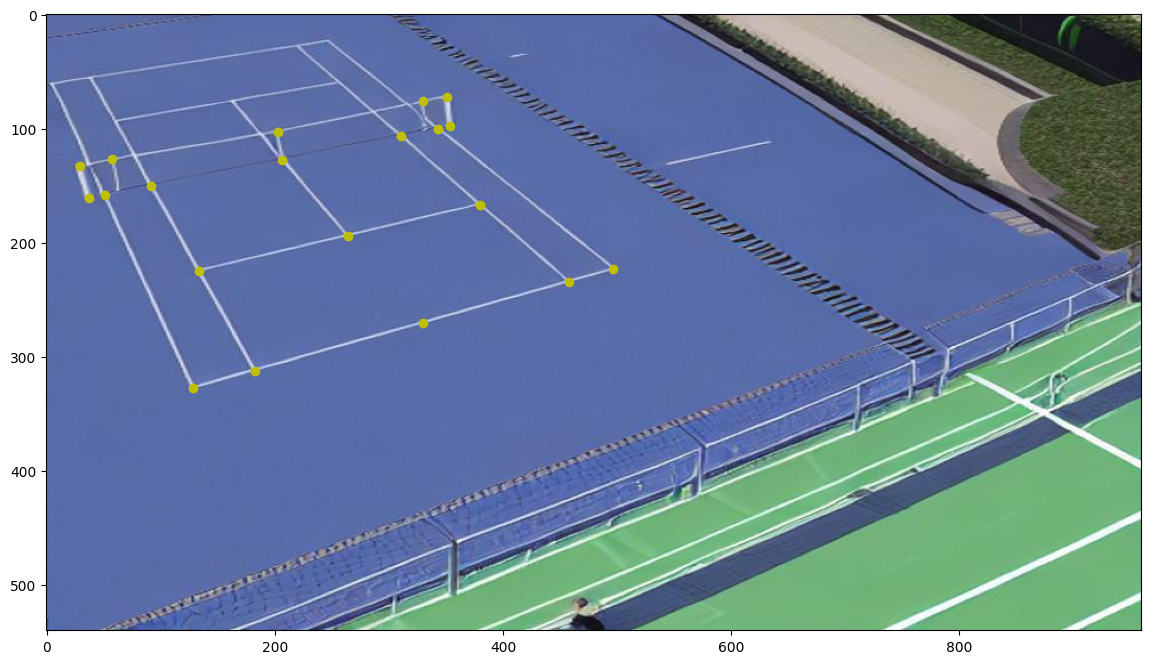

In [ ]:
import glob
import json
import cv2

files = glob.glob('tennis/*.json')

fname = files[-2]
print(fname)
params = json.load(open(fname,'r',encoding='utf8'))

#im = cv2.imread(fname[:-5]+'.png')
#imm = cv2.imread(fname.replace('court_','courtpts_'))
#imm = cv2.imread(fname.replace('court_','courtpts_'))
# tennis/bg/court_0482_BG0000.jpg
im = cv2.imread(fname.replace('court_','bg/court_')[:-5]+'_BG0000.jpg')
imshow(im[:,:,::-1])

ih, iw = im.shape[:2]

p2 = [iw,ih]*trans(params)[:,:2]
p2[:,1] = ih - p2[:,1]
plot(p2[:,0],p2[:,1],'yo')

In [ ]:
files[0]

'tennis/court_0033.json'

In [ ]:
imread(files[0][:-5]+'.png').shape

(540, 960, 4)

In [ ]:
json_dict = {}
for fname in files:
    dc = {}
    #im = cv2.imread(fname[:-5]+'.png')
    imname = fname.replace('court_','bg/court_')[:-5]+'_BG0000.jpg'
    im = cv2.imread(imname)
    params = json.load(open(fname,'r',encoding='utf8'))
    ih, iw = im.shape[:2]
    p2 = [iw,ih]*trans(params)[:,:2]
    p2[:,1] = ih - p2[:,1]
    dc['json_path'] = fname
    dc['img_path'] = imname
    dc['joints'] = [ (xy[0]/960.0*IMG_SIZE,xy[1]/540.0*IMG_SIZE,1) for xy in p2 ]
    json_dict[fname] = dc

## Load data

The authors also provide a metadata file that specifies additional information about the
keypoints, like color information, animal pose name, etc. We will load this file in a `pandas`
dataframe to extract information for visualization purposes.

A single entry of `json_dict` looks like the following:

```
'n02085782-Japanese_spaniel/n02085782_2886.jpg':
{'img_bbox': [205, 20, 116, 201],
 'img_height': 272,
 'img_path': 'n02085782-Japanese_spaniel/n02085782_2886.jpg',
 'img_width': 350,
 'is_multiple_dogs': False,
 'joints': [[108.66666666666667, 252.0, 1],
            [147.66666666666666, 229.0, 1],
            [163.5, 208.5, 1],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [54.0, 244.0, 1],
            [77.33333333333333, 225.33333333333334, 1],
            [79.0, 196.5, 1],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [150.66666666666666, 86.66666666666667, 1],
            [88.66666666666667, 73.0, 1],
            [116.0, 106.33333333333333, 1],
            [109.0, 123.33333333333333, 1],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0]],
 'seg': ...}
```

In this example, the keys we are interested in are:

* `img_path`
* `joints`

There are a total of 24 entries present inside `joints`. Each entry has 3 values:

* x-coordinate
* y-coordinate
* visibility flag of the keypoints (1 indicates visibility and 0 indicates non-visibility)

As we can see `joints` contain multiple `[0, 0, 0]` entries which denote that those
keypoints were not labeled. In this example, we will consider both non-visible as well as
unlabeled keypoints in order to allow mini-batch learning.

In [ ]:
colors = [ ''.join(map(lambda a: f'{a:02x}',x)) for x in (255*rand(20,3)).astype('u1') ]

In [ ]:

import cv2

# Extract the colours and labels.
colours = [ ''.join(map(lambda a: f'{a:02x}',x)) for x in (255*rand(20,3)).astype('u1') ]
colours = ["#" + colour for colour in colours]

# Utility for reading an image and for getting its annotations.
def get_dog(name):
    data = json_dict[name]
    img_data = plt.imread(data["img_path"])
    img_data = cv2.resize(img_data,(IMG_SIZE,IMG_SIZE))
    # If the image is RGBA convert it to RGB.
    if img_data.shape[-1] == 4:
        img_data = img_data[:,:,:3]
    data["img_data"] = (img_data*255).astype('u1')

    return data


In [ ]:
m = get_dog(files[0])

In [ ]:
m['img_data'].dtype, m['img_data'].shape

(dtype('uint8'), (224, 224, 3))

In [ ]:
m

{'json_path': 'tennis/court_0130.json',
 'img_path': 'tennis/bg/court_0130_BG0000.jpg',
 'joints': [(40.69450599981856, 122.50483417601914, 1),
  (51.920960126411, 120.26734928669147, 1),
  (83.45674908265127, 113.98211884198012, 1),
  (112.11899739012779, 108.26959850751166, 1),
  (121.01606840285166, 106.49637058302477, 1),
  (47.90049925396088, 100.59866614469165, 1),
  (75.08258288092986, 96.0182865227575, 1),
  (100.12874295988868, 91.79782561888698, 1),
  (33.54442770509402, 85.54098602229173, 1),
  (36.31757946758833, 85.14506550849951, 1),
  (44.50276912410816, 83.97647295683142, 1),
  (67.91113657573752, 80.63448028487244, 1),
  (89.73462026571329, 77.51876011689295, 1),
  (96.6844264724148, 76.52654220753531, 1),
  (98.9666909756847, 76.200705249398, 1),
  (32.8638716151254, 74.77492354367931, 1),
  (38.44071902759554, 74.06785271523688, 1),
  (67.58237868096414, 71.34315969928598, 1),
  (94.24612337784399, 66.99246216442828, 1),
  (98.86461253844499, 66.406898544804, 1)],
 '

## Visualize data

Now, we write a utility function to visualize the images and their keypoints.

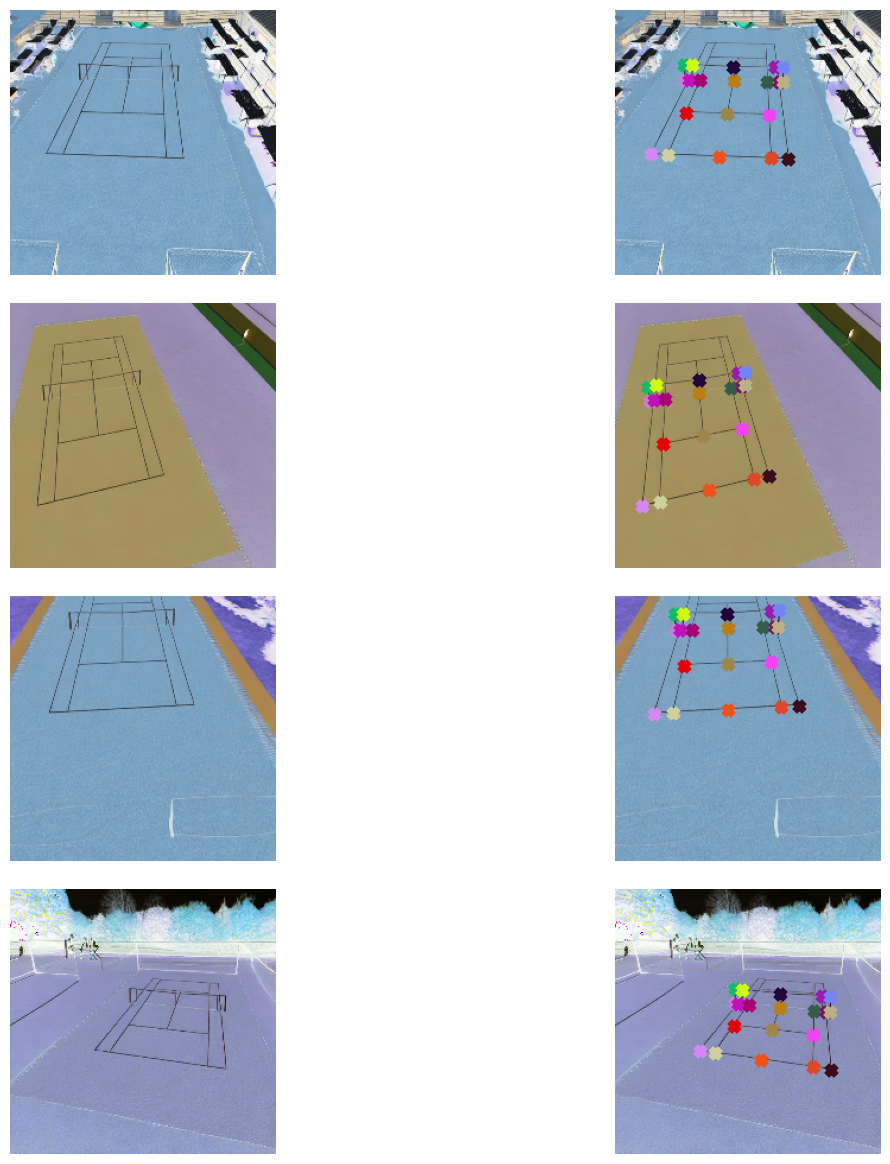

In [ ]:
# Parts of this code come from here:
# https://github.com/benjiebob/StanfordExtra/blob/master/demo.ipynb
def visualize_keypoints(images, keypoints):
    fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(16, 12))
    [ax.axis("off") for ax in np.ravel(axes)]

    for (ax_orig, ax_all), image, current_keypoint in zip(axes, images, keypoints):
        ax_orig.imshow(image)
        ax_all.imshow(image)

        # If the keypoints were formed by `imgaug` then the coordinates need
        # to be iterated differently.
        if isinstance(current_keypoint, KeypointsOnImage):
            for idx, kp in enumerate(current_keypoint.keypoints):
                ax_all.scatter(
                    [kp.x], [kp.y], c=colours[idx], marker="x", s=50, linewidths=5
                )
        else:
            current_keypoint = np.array(current_keypoint)
            # Since the last entry is the visibility flag, we discard it.
            current_keypoint = current_keypoint[:, :2]
            for idx, (x, y) in enumerate(current_keypoint):
                ax_all.scatter([x], [y], c=colours[idx], marker="x", s=50, linewidths=5)

    plt.tight_layout(pad=2.0)
    plt.show()


# Select four samples randomly for visualization.
samples = list(json_dict.keys())
num_samples = 4
selected_samples = np.random.choice(samples, num_samples, replace=False)

images, keypoints = [], []

for sample in selected_samples:
    data = get_dog(sample)
    image = data["img_data"]
    keypoint = data["joints"]

    images.append(image)
    keypoints.append(keypoint)

visualize_keypoints(images, keypoints)

The plots show that we have images of non-uniform sizes, which is expected in most
real-world scenarios. However, if we resize these images to have a uniform shape (for
instance (224 x 224)) their ground-truth annotations will also be affected. The same
applies if we apply any geometric transformation (horizontal flip, for e.g.) to an image.
Fortunately, `imgaug` provides utilities that can handle this issue.
In the next section, we will write a data generator inheriting the
[`keras.utils.Sequence`](https://keras.io/api/utils/python_utils/#sequence-class) class
that applies data augmentation on batches of data using `imgaug`.

## Prepare data generator

In [ ]:

class KeyPointsDataset(keras.utils.Sequence):
    def __init__(self, image_keys, aug, batch_size=BATCH_SIZE, train=True):
        self.image_keys = image_keys
        self.aug = aug
        self.batch_size = batch_size
        self.train = train
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_keys) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_keys))
        if self.train:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        image_keys_temp = [self.image_keys[k] for k in indexes]
        (images, keypoints) = self.__data_generation(image_keys_temp)

        return (images, keypoints)

    def __data_generation(self, image_keys_temp):
        batch_images = np.empty((self.batch_size, IMG_SIZE, IMG_SIZE, 3), dtype="int")
        batch_keypoints = np.empty(
            (self.batch_size, 1, 1, NUM_KEYPOINTS), dtype="float32"
        )

        for i, key in enumerate(image_keys_temp):
            data = get_dog(key)
            current_keypoint = np.array(data["joints"])[:, :2]
            kps = []

            # To apply our data augmentation pipeline, we first need to
            # form Keypoint objects with the original coordinates.
            for j in range(0, len(current_keypoint)):
                kps.append(Keypoint(x=current_keypoint[j][0], y=current_keypoint[j][1]))

            # We then project the original image and its keypoint coordinates.
            current_image = data["img_data"]
            kps_obj = KeypointsOnImage(kps, shape=current_image.shape)

            # Apply the augmentation pipeline.
            (new_image, new_kps_obj) = self.aug(image=current_image, keypoints=kps_obj)
            batch_images[i,] = new_image

            # Parse the coordinates from the new keypoint object.
            kp_temp = []
            for keypoint in new_kps_obj:
                kp_temp.append(np.nan_to_num(keypoint.x))
                kp_temp.append(np.nan_to_num(keypoint.y))

            # More on why this reshaping later.
            batch_keypoints[i,] = np.array(kp_temp).reshape(1, 1, 20 * 2)

        # Scale the coordinates to [0, 1] range.
        batch_keypoints = batch_keypoints / IMG_SIZE

        return (batch_images, batch_keypoints)


To know more about how to operate with keypoints in `imgaug` check out
[this document](https://imgaug.readthedocs.io/en/latest/source/examples_keypoints.html).

## Define augmentation transforms

In [ ]:
train_aug = iaa.Sequential(
    [
        iaa.Resize(IMG_SIZE, interpolation="linear"),
        iaa.Fliplr(0.3),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        iaa.Sometimes(0.3, iaa.Affine(rotate=10, scale=(0.5, 0.7))),
    ]
)

test_aug = iaa.Sequential([iaa.Resize(IMG_SIZE, interpolation="linear")])

## Create training and validation splits

In [ ]:
np.random.shuffle(samples)
train_keys, validation_keys = (
    samples[int(len(samples) * 0.15) :],
    samples[: int(len(samples) * 0.15)],
)


In [ ]:
train_dataset = KeyPointsDataset(train_keys, train_aug)

In [ ]:
len(validation_keys)

75

In [ ]:
sample_keypoints

array([[[144.36264 , 120.3131  ],
        [135.31264 , 119.911285],
        [108.554924, 118.72329 ],
        [ 82.37092 , 117.56075 ],
        [ 73.84988 , 117.18244 ],
        [134.95883 , 104.8986  ],
        [111.83433 , 104.012375],
        [ 89.139   , 103.1426  ],
        [143.62862 ,  92.161316],
        [141.37825 ,  92.086945],
        [134.65164 ,  91.86464 ],
        [114.68941 ,  91.20491 ],
        [ 95.04743 ,  90.55577 ],
        [ 88.56995 ,  90.3417  ],
        [ 86.41846 ,  90.27059 ],
        [143.82266 ,  82.99862 ],
        [139.29814 ,  82.86583 ],
        [114.70418 ,  82.995544],
        [ 90.59754 ,  81.43656 ],
        [ 86.26516 ,  81.30941 ]],

       [[145.30502 , 142.48508 ],
        [137.73297 , 143.31502 ],
        [113.854195, 145.93227 ],
        [ 88.06904 , 148.75848 ],
        [ 79.09887 , 149.74167 ],
        [130.8867  , 114.25125 ],
        [110.64758 , 115.51015 ],
        [ 89.062546, 116.85275 ],
        [132.54001 ,  89.898636],
        [130

## Data generator investigation

In [ ]:
sample_images[0].dtype

dtype('int64')

Total batches in training set: 106
Total batches in validation set: 18


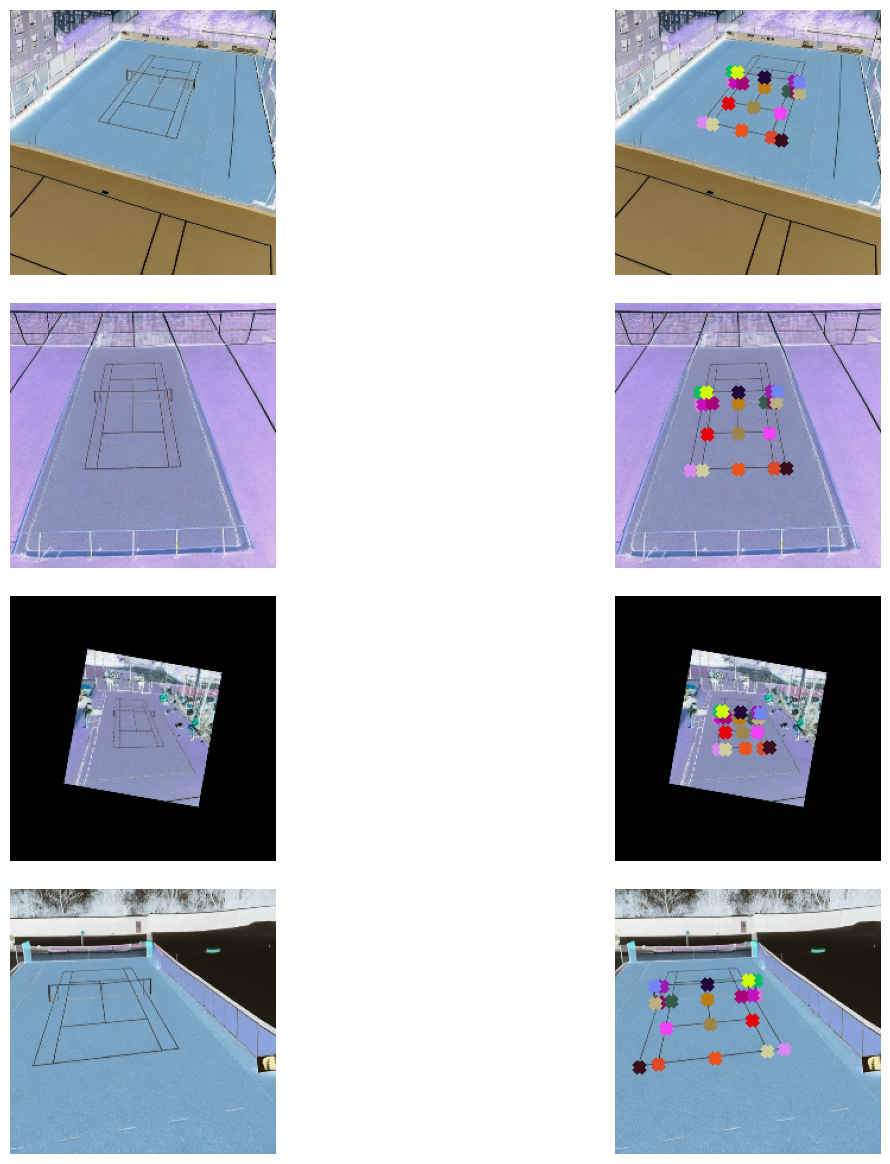

In [ ]:
train_dataset = KeyPointsDataset(train_keys, train_aug)
validation_dataset = KeyPointsDataset(validation_keys, test_aug, train=False)

print(f"Total batches in training set: {len(train_dataset)}")
print(f"Total batches in validation set: {len(validation_dataset)}")

sample_images, sample_keypoints = next(iter(train_dataset))
assert sample_keypoints.max() <= 1.0
assert sample_keypoints.min() >= 0.0

sample_keypoints = sample_keypoints[:4].reshape(-1, 20, 2) * IMG_SIZE
visualize_keypoints(sample_images[:4], sample_keypoints)

## Model building

The [Stanford dogs dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) (on which
the StanfordExtra dataset is based) was built using the [ImageNet-1k dataset](http://image-net.org/).
So, it is likely that the models pretrained on the ImageNet-1k dataset would be useful
for this task. We will use a MobileNetV2 pre-trained on this dataset as a backbone to
extract meaningful features from the images and then pass those to a custom regression
head for predicting coordinates.

In [ ]:

def get_model():
    # Load the pre-trained weights of MobileNetV2 and freeze the weights
    backbone = keras.applications.MobileNetV2(
        weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    backbone.trainable = False

    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    x = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=5, strides=1, activation="relu"
    )(x)
    outputs = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=3, strides=1, activation="sigmoid"
    )(x)

    return keras.Model(inputs, outputs, name="keypoint_detector")


Our custom network is fully-convolutional which makes it more parameter-friendly than the
same version of the network having fully-connected dense layers.

In [ ]:
get_model().summary()

Model: "keypoint_detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 dropout_2 (Dropout)         (None, 7, 7, 1280)        0         
                                                 

Notice the output shape of the network: `(None, 1, 1, 48)`. This is why we have reshaped
the coordinates as: `batch_keypoints[i, :] = np.array(kp_temp).reshape(1, 1, 24 * 2)`.

## Model compilation and training

For this example, we will train the network only for five epochs.

In [ ]:
model = get_model()
model.compile(loss="mse", optimizer=keras.optimizers.Adam(1e-4))
model.fit(train_dataset, validation_data=validation_dataset, epochs=EPOCHS)

Epoch 1/5
106/106 [==============================] - 10s 57ms/step - loss: 0.0236 - val_loss: 0.0266
Epoch 2/5
106/106 [==============================] - 5s 44ms/step - loss: 0.0189 - val_loss: 0.0196
Epoch 3/5
106/106 [==============================] - 4s 37ms/step - loss: 0.0152 - val_loss: 0.0173
Epoch 4/5
106/106 [==============================] - 5s 48ms/step - loss: 0.0148 - val_loss: 0.0154
Epoch 5/5
106/106 [==============================] - 5s 42ms/step - loss: 0.0129 - val_loss: 0.0136


In [ ]:
model.fit(train_dataset, validation_data=validation_dataset, epochs=100)

Epoch 1/100
106/106 [==============================] - 6s 54ms/step - loss: 0.0056 - val_loss: 0.0067
Epoch 2/100
106/106 [==============================] - 4s 38ms/step - loss: 0.0057 - val_loss: 0.0064
Epoch 3/100
106/106 [==============================] - 5s 48ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 4/100
106/106 [==============================] - 5s 44ms/step - loss: 0.0057 - val_loss: 0.0073
Epoch 5/100
106/106 [==============================] - 5s 43ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 6/100
106/106 [==============================] - 4s 36ms/step - loss: 0.0056 - val_loss: 0.0074
Epoch 7/100
106/106 [==============================] - 6s 53ms/step - loss: 0.0054 - val_loss: 0.0060
Epoch 8/100
106/106 [==============================] - 4s 36ms/step - loss: 0.0049 - val_loss: 0.0054
Epoch 9/100
106/106 [==============================] - 6s 56ms/step - loss: 0.0051 - val_loss: 0.0057
Epoch 10/100
106/106 [==============================] - 4s 38ms/step - loss: 0.005

KeyboardInterrupt: ignored

## Make predictions and visualize them

1/1 [==============================] - 0s 28ms/step


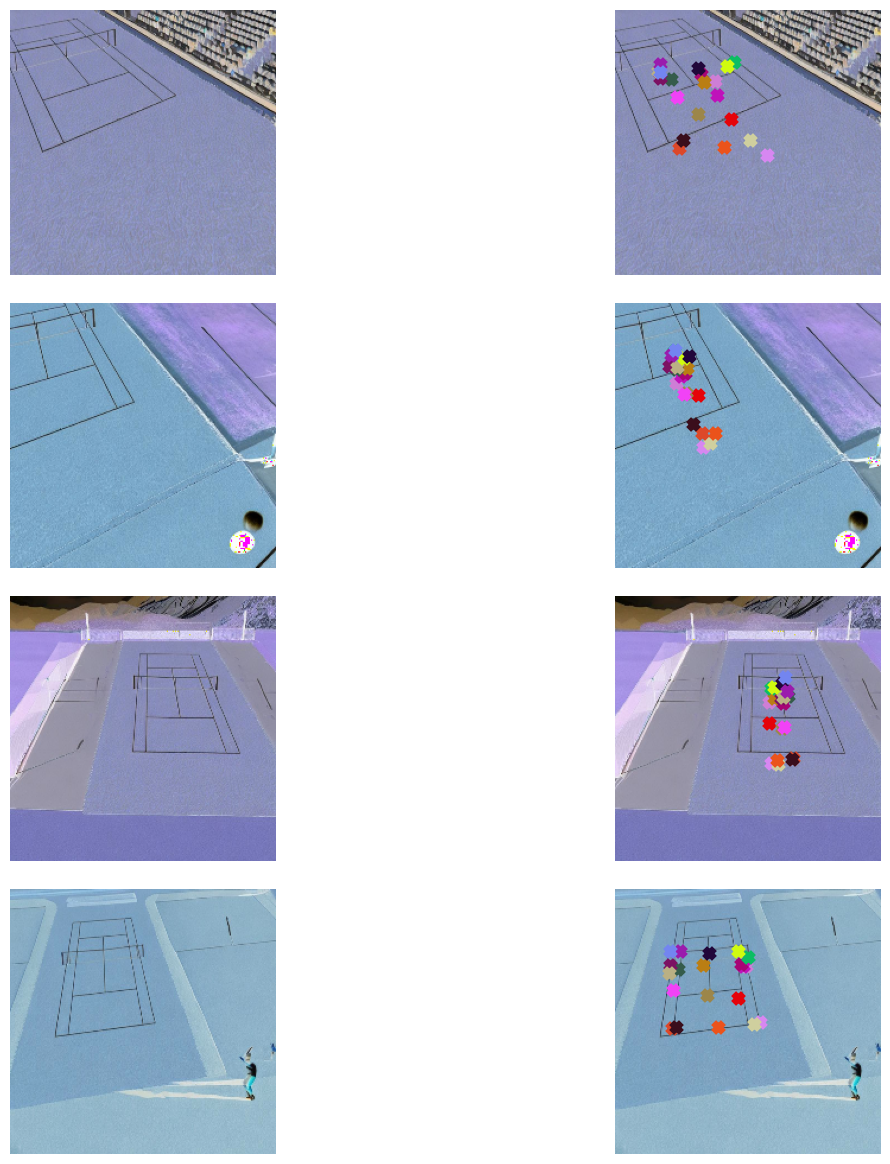

In [ ]:
sample_val_images, sample_val_keypoints = next(iter(validation_dataset))
sample_val_images = sample_val_images[:4]
sample_val_keypoints = sample_val_keypoints[:4].reshape(-1, 20, 2) * IMG_SIZE
predictions = model.predict(sample_val_images).reshape(-1, 20, 2) * IMG_SIZE

# Ground-truth
#visualize_keypoints(sample_val_images, sample_val_keypoints)

# Predictions
visualize_keypoints(sample_val_images, predictions)

Predictions will likely improve with more training.

## Going further

* Try using other augmentation transforms from `imgaug` to investigate how that changes
the results.
* Here, we transferred the features from the pre-trained network linearly that is we did
not [fine-tune](https://keras.io/guides/transfer_learning/) it. You are encouraged to fine-tune it on this task and see if that
improves the performance. You can also try different architectures and see how they
affect the final performance.